## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 4 - Estratégias de Treinamento e Transferência de Aprendizado</span>

#### <span style="color:darkred">**Parte 1: Regularização (Dropout) e Normalização**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from numpy.random import seed
from tensorflow.random import set_seed

tfds.disable_progress_bar()

Carregando a base de dados "Cats vs Dogs"

Vamos ainda re-dimensionar as imagens para o tamanho $150\times 150$

Posteriormente, para aumentar a velocidade, vamos pré-calcular os batches

In [2]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[0%:25%]", "train[25%:30%]", "train[30%:50%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [3]:
# definindo tamanho de batch e colocando os batches num "cache"
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

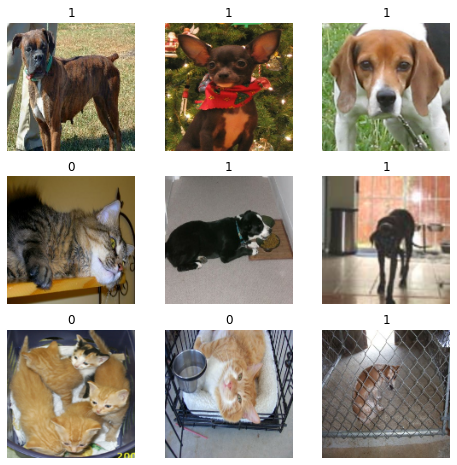

In [4]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

### 1) Vamos investigar uma CNN sequencial, e adicionar opções de Dropout (regularização), e normalização por batch e por camada

In [5]:
def my_cnn(input_shape, num_classes, dropout_rate=0.0, batch_norm=False, layer_norm=False):
    
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    
    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    # guarda ativacao para somar ao fim do bloco residual
    ativacao_residual = x 

    for n_filtros in [64,64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(n_filtros, 1, strides=2, padding="same")(
            ativacao_residual
        )
        x = layers.add([x, residual])  # adiciona resisual
        ativacao_residual = x  # armazena saida do bloco

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        neuronios = 1
    else:
        activation = "softmax"
        neuronios = num_classes

    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(neuronios, activation=activation)(x)

    return keras.Model(inputs, outputs)

### I - Avaliando o papel da Normalização

In [6]:
seed(1)
set_seed(2)

epochs = 6

CNN1 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=False, layer_norm=False)
CNN1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

hist1 = CNN1.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/6
182/182 [==============================] - 17s 93ms/step - loss: 0.6938 - accuracy: 0.4966 - val_loss: 0.6929 - val_accuracy: 0.5082
Epoch 2/6
182/182 [==============================] - 15s 82ms/step - loss: 0.6935 - accuracy: 0.4988 - val_loss: 0.6924 - val_accuracy: 0.5082
Epoch 3/6
182/182 [==============================] - 15s 81ms/step - loss: 0.6932 - accuracy: 0.5069 - val_loss: 0.6919 - val_accuracy: 0.5082
Epoch 4/6
182/182 [==============================] - 15s 81ms/step - loss: 0.6929 - accuracy: 0.5127 - val_loss: 0.6914 - val_accuracy: 0.5090
Epoch 5/6
182/182 [==============================] - 15s 81ms/step - loss: 0.6925 - accuracy: 0.5160 - val_loss: 0.6908 - val_accuracy: 0.5142
Epoch 6/6
182/182 [==============================] - 15s 81ms/step - loss: 0.6921 - accuracy: 0.5199 - val_loss: 0.6901 - val_accuracy: 0.5202


### com Batch Normalization

In [7]:
seed(1)
set_seed(2)

CNN2 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=True, layer_norm=False)

CNN2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

hist2 = CNN2.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/6
      2/Unknown - 0s 76ms/step - loss: 0.6974 - accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0202s vs `on_train_batch_end` time: 0.0621s). Check your callbacks.


182/182 [==============================] - 16s 89ms/step - loss: 0.6629 - accuracy: 0.5997 - val_loss: 0.7100 - val_accuracy: 0.4918
Epoch 2/6
182/182 [==============================] - 16s 89ms/step - loss: 0.6255 - accuracy: 0.6444 - val_loss: 0.7775 - val_accuracy: 0.4918
Epoch 3/6
182/182 [==============================] - 16s 89ms/step - loss: 0.6037 - accuracy: 0.6685 - val_loss: 0.6560 - val_accuracy: 0.5761
Epoch 4/6
182/182 [==============================] - 16s 89ms/step - loss: 0.5837 - accuracy: 0.6924 - val_loss: 0.7798 - val_accuracy: 0.5434
Epoch 5/6
182/182 [==============================] - 16s 89ms/step - loss: 0.5667 - accuracy: 0.7113 - val_loss: 0.9397 - val_accuracy: 0.5434
Epoch 6/6
182/182 [==============================] - 16s 89ms/step - loss: 0.5491 - accuracy: 0.7220 - val_loss: 0.6956 - val_accuracy: 0.6234


### com Layer Normalization

In [8]:
seed(1)
set_seed(2)

CNN3 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=False, layer_norm=True)

CNN3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

hist3 = CNN3.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/6
      2/Unknown - 0s 112ms/step - loss: 0.8941 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0430s vs `on_train_batch_end` time: 0.0949s). Check your callbacks.


182/182 [==============================] - 26s 145ms/step - loss: 0.7572 - accuracy: 0.5007 - val_loss: 0.6929 - val_accuracy: 0.4918
Epoch 2/6
182/182 [==============================] - 26s 143ms/step - loss: 0.7027 - accuracy: 0.5334 - val_loss: 0.6845 - val_accuracy: 0.5787
Epoch 3/6
182/182 [==============================] - 26s 142ms/step - loss: 0.6980 - accuracy: 0.5395 - val_loss: 0.6706 - val_accuracy: 0.5890
Epoch 4/6
182/182 [==============================] - 26s 142ms/step - loss: 0.6925 - accuracy: 0.5619 - val_loss: 0.6759 - val_accuracy: 0.6260
Epoch 5/6
182/182 [==============================] - 26s 143ms/step - loss: 0.6839 - accuracy: 0.5652 - val_loss: 0.6734 - val_accuracy: 0.5649
Epoch 6/6
182/182 [==============================] - 26s 141ms/step - loss: 0.6741 - accuracy: 0.5865 - val_loss: 0.6262 - val_accuracy: 0.6320


com BN + Regularização Dropout

In [9]:
seed(1)
set_seed(2)

CNN4 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.25, batch_norm=True)

CNN4.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

hist4 = CNN4.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/6
      2/Unknown - 0s 77ms/step - loss: 0.7238 - accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0711s). Check your callbacks.


182/182 [==============================] - 17s 91ms/step - loss: 0.6746 - accuracy: 0.5923 - val_loss: 0.7084 - val_accuracy: 0.4918
Epoch 2/6
182/182 [==============================] - 16s 86ms/step - loss: 0.6442 - accuracy: 0.6300 - val_loss: 0.8410 - val_accuracy: 0.4918
Epoch 3/6
182/182 [==============================] - 16s 86ms/step - loss: 0.6154 - accuracy: 0.6584 - val_loss: 0.5841 - val_accuracy: 0.6862
Epoch 4/6
182/182 [==============================] - 16s 86ms/step - loss: 0.5960 - accuracy: 0.6792 - val_loss: 0.5747 - val_accuracy: 0.7008
Epoch 5/6
182/182 [==============================] - 16s 85ms/step - loss: 0.5783 - accuracy: 0.6960 - val_loss: 0.5583 - val_accuracy: 0.6999
Epoch 6/6
182/182 [==============================] - 16s 90ms/step - loss: 0.5639 - accuracy: 0.7177 - val_loss: 0.5280 - val_accuracy: 0.7395


**Resumo: avaliando os modelos**

In [10]:
scores1 = CNN1.evaluate(test_ds, verbose=0)
scores2 = CNN2.evaluate(test_ds, verbose=0)
scores3 = CNN3.evaluate(test_ds, verbose=0)
scores4 = CNN4.evaluate(test_ds, verbose=0)

In [11]:
print(scores1)

[0.6924049854278564, 0.5045141577720642]


In [12]:
print("BatchNorm LayerNorm Dropout - Loss\tAcc")
print("    -         -        -      %.4f\t%.4f" % (scores1[0],scores1[1]))
print("    X         -        -      %.4f\t%.4f" % (scores2[0],scores2[1]))
print("    -         X        -      %.4f\t%.4f" % (scores3[0],scores3[1]))
print("    X         -        X      %.4f\t%.4f" % (scores4[0],scores4[1]))

BatchNorm LayerNorm Dropout - Loss	Acc
    -         -        -      0.6924	0.5045
    X         -        -      0.6801	0.6402
    -         X        -      0.6295	0.6307
    X         -        X      0.5360	0.7309
